In [24]:
pip install pandas numpy matplotlib scipy

In [25]:

import os
import warnings
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8, 5)

In [26]:
trader_data_path = "historical_data.csv"   # <- set to your downloaded file
sentiment_data_path = "fear_greed_index.csv"      # <- set to your downloaded file
OUTPUT_DIR = "analysis_outputs"
PLOTS_DIR = os.path.join(OUTPUT_DIR, "plots")

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

In [27]:
def safe_read_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}. Download it and update path.")
    return pd.read_csv(path)


# ---------------------------
# 1. Load datasets
# ---------------------------
print("Loading datasets...")

Loading datasets...


In [28]:
trader_df = safe_read_csv(trader_data_path)
sent_df = safe_read_csv(sentiment_data_path)

print(f"Trader data shape: {trader_df.shape}")
print(f"Sentiment data shape: {sent_df.shape}")

Trader data shape: (211224, 16)
Sentiment data shape: (2644, 4)


In [29]:
# 2. Basic cleaning & datetime parsing
# ---------------------------
print("Parsing dates and cleaning up columns...")

# Try to find likely timestamp columns in trader_df
time_cols = [c for c in trader_df.columns if "time" in c.lower() or "timestamp" in c.lower()]
if not time_cols:
    # assume column named 'time' exists per spec
    time_cols = ["time"]

time_col = time_cols[0]
print(f"Using time column: {time_col}")

# Parse trader timestamps
trader_df[time_col] = pd.to_datetime(trader_df[time_col], errors="coerce")
if trader_df[time_col].isnull().sum() > 0:
    print(f"Warning: {trader_df[time_col].isnull().sum()} NaT values found in {time_col}")

# Parse sentiment dates
# Common possible column names: Date, date, Day
sent_date_col = None
for candidate in ["Date", "date", "day", "Day"]:
    if candidate in sent_df.columns:
        sent_date_col = candidate
        break
if sent_date_col is None:
    raise ValueError("Could not find Date column in sentiment file. Rename to 'Date' or similar.")
sent_df[sent_date_col] = pd.to_datetime(sent_df[sent_date_col], errors="coerce")
sent_df = sent_df.dropna(subset=[sent_date_col]).copy()

# Make sure classification column exists
class_col = None
for candidate in ["Classification", "classification", "Classification " , "sentiment", "Sentiment"]:
    if candidate in sent_df.columns:
        class_col = candidate
        break
if class_col is None:
    raise ValueError("Could not find Classification (Fear/Greed) column in sentiment file. Rename accordingly.")
sent_df.rename(columns={sent_date_col: "sent_date", class_col: "sentiment"}, inplace=True)
sent_df["sentiment"] = sent_df["sentiment"].astype(str).str.strip().str.title()  # 'Fear' / 'Greed'

# Standardize trader 'time' -> trade_datetime, and extract date
trader_df.rename(columns={time_col: "trade_datetime"}, inplace=True)
trader_df["trade_date"] = pd.to_datetime(trader_df["trade_datetime"].dt.date)

Parsing dates and cleaning up columns...
Using time column: Timestamp IST


In [30]:
# 3. Ensure numeric columns
# ---------------------------
# Common names for PnL and leverage
possible_pnl = [c for c in trader_df.columns if c.lower().replace("_","").find("pnl")!=-1 or "closedpnl" in c.lower()]
pnl_col = possible_pnl[0] if possible_pnl else None
if pnl_col is None:
    print("Warning: Could not automatically find PnL column (closedPnL). Please ensure it is present.")
else:
    print(f"Using PnL column: {pnl_col}")
    trader_df[pnl_col] = pd.to_numeric(trader_df[pnl_col], errors="coerce")

possible_lev = [c for c in trader_df.columns if "leverage" in c.lower()]
lev_col = possible_lev[0] if possible_lev else None
if lev_col:
    trader_df[lev_col] = pd.to_numeric(trader_df[lev_col], errors="coerce")

# Fill missing sizes/prices as numeric where possible
for col in ["size", "execution price", "execution_price", "price", "size"]:
    if col in trader_df.columns:
        trader_df[col] = pd.to_numeric(trader_df[col], errors="coerce")

Using PnL column: Closed PnL


In [31]:
# 4. Merge sentiment -> trader data
# ---------------------------
print("Merging sentiment with trader data on date...")
merged = pd.merge(
    trader_df,
    sent_df[["sent_date", "sentiment"]],
    left_on="trade_date",
    right_on="sent_date",
    how="left"
)

# If there are missing sentiment rows, optionally fill using nearest date (1-day tolerance)
missing_sent = merged["sentiment"].isnull().sum()
print(f"Trades with missing sentiment after direct merge: {missing_sent}")

if missing_sent > 0:
    # forward/backward fill by matching nearest date within 1 day
    # create mapping from date->sentiment
    sent_map = sent_df.set_index("sent_date")["sentiment"]
    def lookup_sent(d):
        if pd.isna(d):
            return np.nan
        # exact
        if d in sent_map:
            return sent_map[d]
        # nearest in +-1 day
        for delta in [1, -1, 2, -2]:
            nd = d + pd.Timedelta(days=delta)
            if nd in sent_map:
                return sent_map[nd]
        return np.nan
    merged["sentiment"] = merged["trade_date"].map(lookup_sent)

still_missing = merged["sentiment"].isnull().sum()
print(f"Still missing sentiment: {still_missing}")

# Drop rows with no sentiment if too many are missing or if needed
merged = merged.dropna(subset=["sentiment"]).copy()
print(f"After dropping missing-sentiment rows: {merged.shape}")

Merging sentiment with trader data on date...
Trades with missing sentiment after direct merge: 175360
Still missing sentiment: 173340
After dropping missing-sentiment rows: (37884, 19)


In [32]:
# 5. Feature engineering
print("Feature engineering...")

# Standard binary flag: 1 if Greed else 0 for Fear
merged["sent_flag"] = merged["sentiment"].map(lambda x: 1 if str(x).strip().lower()=="greed" else 0)

# Ensure pnl column - use pnl_col if found else try common name
if pnl_col is None:
    # try common names
    for c in ["closedPnL", "closed_pnl", "pnl", "PnL"]:
        if c in merged.columns:
            pnl_col = c
            merged[pnl_col] = pd.to_numeric(merged[pnl_col], errors="coerce")
            break

if pnl_col is None:
    raise ValueError("No PnL column found. Please provide closedPnL column in trader dataset.")

# create trade-level profit indicator
merged["is_win"] = merged[pnl_col] > 0

# daily aggregates: group per account per day
group_cols = ["Account", "trade_date"]
agg = merged.groupby(group_cols).agg(
    trades_count=("trade_datetime", "count"),
    total_pnl=(pnl_col, "sum"),
    avg_pnl=(pnl_col, "mean"),
    win_rate=( "is_win", "mean"),
    avg_leverage=(lev_col, "mean") if lev_col else pd.NamedAgg(column=pnl_col, aggfunc=lambda x: np.nan)
).reset_index()

# attach sentiment by day: if a day has mixed sentiments (rare here since sentiment is daily), use mode
day_sent = merged.groupby("trade_date")["sentiment"].agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan).reset_index().rename(columns={"sentiment":"day_sentiment"})
agg = agg.merge(day_sent, on="trade_date", how="left")

Feature engineering...


In [33]:
# 6. Aggregate analysis by sentiment
print("Aggregating performance by sentiment (trade-level and daily-trader-level)...")
# Trade-level stats
trade_level = merged.groupby("sentiment").agg(
    avg_pnl=(pnl_col, "mean"),
    median_pnl=(pnl_col, "median"),
    total_pnl=(pnl_col, "sum"),
    trade_count=(pnl_col, "count"),
    win_rate=("is_win", "mean"),
    avg_leverage=(lev_col, "mean") if lev_col else pd.NamedAgg(column=pnl_col, aggfunc=lambda x: np.nan)
).reset_index()

# Day-account level stats (agg)
day_acc_level = agg.groupby("day_sentiment").agg(
    avg_total_pnl=("total_pnl", "mean"),
    median_total_pnl=("total_pnl", "median"),
    avg_trades=("trades_count", "mean"),
    avg_win_rate=("win_rate", "mean"),
    avg_leverage=("avg_leverage", "mean")
).reset_index().rename(columns={"day_sentiment":"sentiment"})

print("\nTrade-level summary by sentiment:")
print(trade_level)

print("\nDay-account-level summary by sentiment:")
print(day_acc_level)


Aggregating performance by sentiment (trade-level and daily-trader-level)...

Trade-level summary by sentiment:
       sentiment     avg_pnl  median_pnl     total_pnl  trade_count  win_rate  \
0   Extreme Fear    1.891632     0.00000  4.399937e+03         2326  0.292777   
1  Extreme Greed  205.816345     0.96048  1.156894e+06         5621  0.553282   
2           Fear  128.287950     0.00000  1.779226e+06        13869  0.381787   
3          Greed   68.725078     0.00000  9.148682e+05        13312  0.479868   
4        Neutral   27.088803     0.00000  7.465674e+04         2756  0.494920   

   avg_leverage  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  

Day-account-level summary by sentiment:
       sentiment  avg_total_pnl  median_total_pnl  avg_trades  avg_win_rate  \
0   Extreme Fear     133.331411          0.000000   70.484848      0.173498   
1  Extreme Greed   10329.407818        108.938997   50.187500      0.335945   
2           Fea

In [34]:
# 7. Per-trader performance (consistency across sentiments)

print("Computing per-trader metrics...")
per_trader = merged.groupby("Account").agg(
    total_trades=("trade_datetime", "count"),
    total_pnl=(pnl_col, "sum"),
    avg_pnl=(pnl_col, "mean"),
    win_rate=("is_win", "mean"),
    avg_leverage=(lev_col, "mean") if lev_col else pd.NamedAgg(column=pnl_col, aggfunc=lambda x: np.nan)
).reset_index()

# also compute performance split by sentiment per trader
split = merged.pivot_table(index="Account", columns="sentiment", values=pnl_col, aggfunc=["count","sum","mean"])
# flatten columns
split.columns = ['_'.join([str(a) for a in col]).strip() for col in split.columns.values]
per_trader = per_trader.merge(split, left_on="Account", right_index=True, how="left")

Computing per-trader metrics...


In [35]:
# 8. Statistical test: are pnls different between Fear and Greed?

print("Running basic statistical tests on PnL distribution between Fear and Greed...")

pnl_fear = merged.loc[merged["sentiment"].str.lower()=="fear", pnl_col].dropna()
pnl_greed = merged.loc[merged["sentiment"].str.lower()=="greed", pnl_col].dropna()

# Check distributions
print(f"Fear records: {len(pnl_fear)}, Greed records: {len(pnl_greed)}")

# Use Mann-Whitney U (non-parametric) and t-test (with unequal var) as references
res_mw = stats.mannwhitneyu(pnl_greed, pnl_fear, alternative="two-sided") if len(pnl_greed)>0 and len(pnl_fear)>0 else None
res_t = stats.ttest_ind(pnl_greed, pnl_fear, equal_var=False, nan_policy="omit") if len(pnl_greed)>1 and len(pnl_fear)>1 else None

print("Mann-Whitney U:", res_mw)
print("T-test (unequal var):", res_t)

Running basic statistical tests on PnL distribution between Fear and Greed...
Fear records: 13869, Greed records: 13312
Mann-Whitney U: MannwhitneyuResult(statistic=np.float64(101195330.5), pvalue=np.float64(6.158095147864415e-49))
T-test (unequal var): TtestResult(statistic=np.float64(-3.5412871748586343), pvalue=np.float64(0.0003988529165719792), df=np.float64(26899.142415828443))


Generating and showing plots...


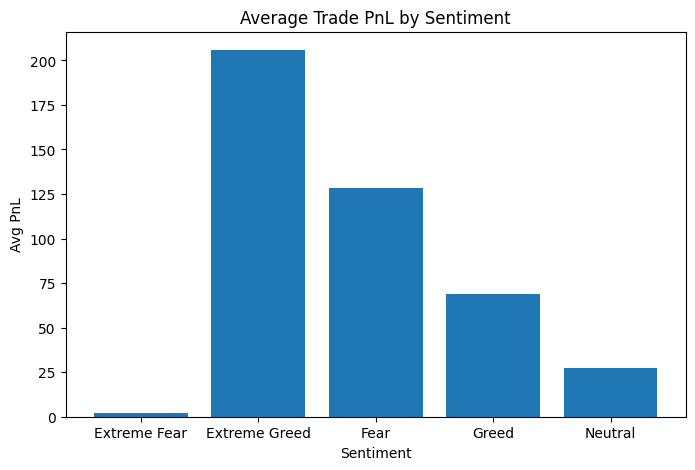

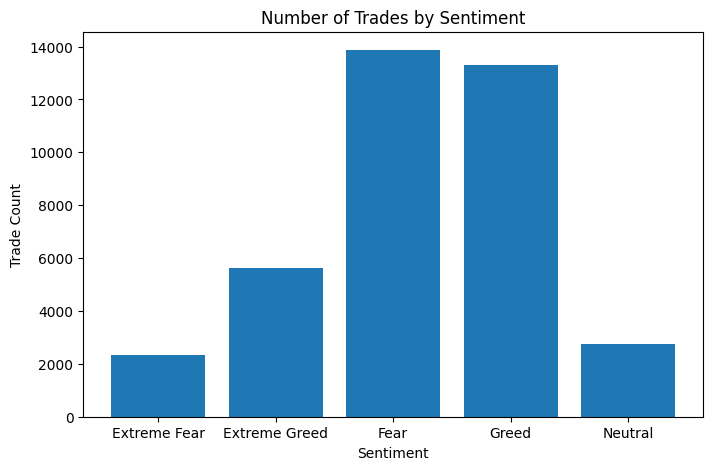

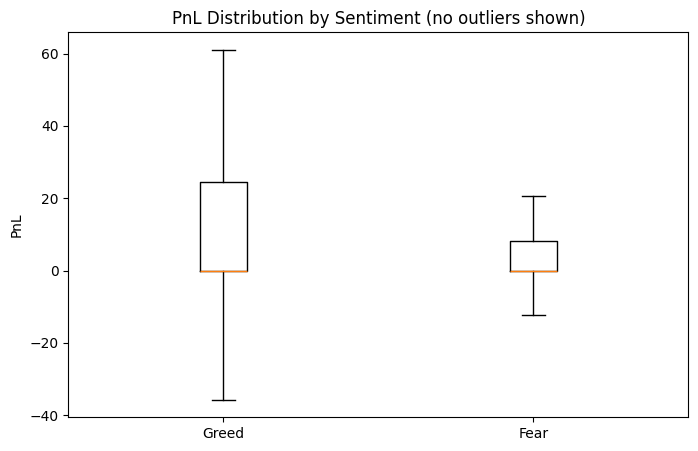

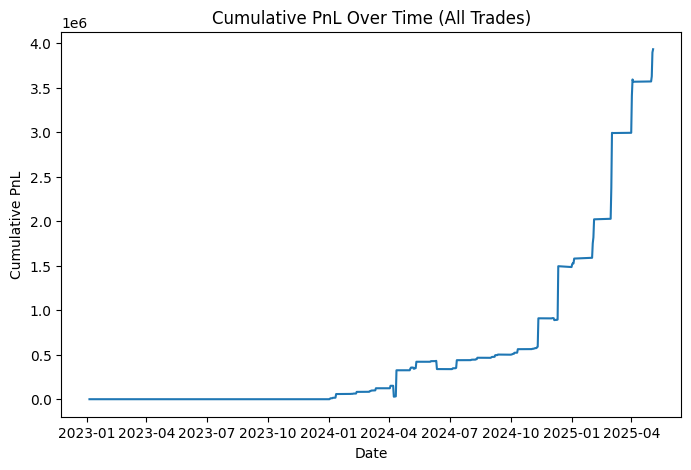

In [36]:
# ---------------------------
# 9. Visualizations (matplotlib)
# ---------------------------
print("Generating and showing plots...")

# 9.1 Average PnL by sentiment (trade-level)
fig, ax = plt.subplots()
ax.bar(trade_level["sentiment"], trade_level["avg_pnl"])
ax.set_title("Average Trade PnL by Sentiment")
ax.set_ylabel("Avg PnL")
ax.set_xlabel("Sentiment")
plt.show()
plt.close(fig)

# 9.2 Trade count by sentiment
fig, ax = plt.subplots()
ax.bar(trade_level["sentiment"], trade_level["trade_count"])
ax.set_title("Number of Trades by Sentiment")
ax.set_ylabel("Trade Count")
ax.set_xlabel("Sentiment")
plt.show()
plt.close(fig)

# 9.3 Boxplot of PnL distribution by sentiment
fig, ax = plt.subplots()
data_for_box = [pnl_greed, pnl_fear]
ax.boxplot(data_for_box, labels=["Greed", "Fear"], showfliers=False)
ax.set_title("PnL Distribution by Sentiment (no outliers shown)")
ax.set_ylabel("PnL")
plt.show()
plt.close(fig)

# 9.4 Average daily PnL over time (cumulative)
daily_pnl = merged.groupby("trade_date")[pnl_col].sum().reset_index()
daily_pnl = daily_pnl.sort_values("trade_date")
daily_pnl["cum_pnl"] = daily_pnl[pnl_col].cumsum()

fig, ax = plt.subplots()
ax.plot(daily_pnl["trade_date"], daily_pnl["cum_pnl"])
ax.set_title("Cumulative PnL Over Time (All Trades)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative PnL")
plt.show()
plt.close(fig)

# 9.5 Leverage distribution by sentiment (if available)
if lev_col:
    fig, ax = plt.subplots()
    greed_lev = merged.loc[merged["sentiment"].str.lower()=="greed", lev_col].dropna()
    fear_lev = merged.loc[merged["sentiment"].str.lower()=="fear", lev_col].dropna()
    ax.boxplot([greed_lev, fear_lev], labels=["Greed", "Fear"], showfliers=False)
    ax.set_title("Leverage Distribution by Sentiment")
    ax.set_ylabel("Leverage")
    plt.show()
    plt.close(fig)




In [37]:
# ---------------------------
# 10. Show and save CSV summaries
# ---------------------------
print("Saving CSV summaries and showing data samples...")

merged.to_csv("merged_cleaned.csv", index=False)
print("\nMerged cleaned dataframe sample:")
print(merged.head())

trade_level.to_csv("trade_level_summary_by_sentiment.csv", index=False)
print("\nTrade level summary:")
print(trade_level)

day_acc_level.to_csv("day_account_summary_by_sentiment.csv", index=False)
print("\nDay account summary by sentiment:")
print(day_acc_level)

per_trader.to_csv("per_trader_summary.csv", index=False)
print("\nPer trader summary sample:")
print(per_trader.head())

Saving CSV summaries and showing data samples...

Merged cleaned dataframe sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side      trade_datetime  Start Position Direction  \
0       986.87   7872.16  BUY 2024-02-12 22:50:00        0.000000       Buy   
1        16.00    127.68  BUY 2024-02-12 22:50:00      986.524596       Buy   
2       144.09   1150.63  BUY 2024-02-12 22:50:00     1002.518996       Buy   
3       142.98   1142.04  BUY 2024-02-12 22:50:00     1146.558564       Buy   
4         8.73     69.75  BUY 2024-02-12 22:50:00     1289.488521       Buy   

   Closed

In [38]:
# 11. Quick Insights summary (print)

print("\n--- Quick insights ---")
print("1) Check trade-level average PnL by sentiment (see trade_level_summary_by_sentiment.csv).")
print("2) Check per-trader summary for traders who perform consistently well/worse across sentiments (per_trader_summary.csv).")
print("3) Mann-Whitney U and t-test results (printed above) indicate whether PnL distributions differ between Greed and Fear.")
print("4) Visual plots saved in", PLOTS_DIR)
print("\nIf you want, next steps I can add:")
print("- Machine learning model to predict probability of trade profit given sentiment + features")
print("- Trader clustering (KMeans) to find groups by behavior")
print("- Time series analysis for sentiment lead/lag effects on PnL")


--- Quick insights ---
1) Check trade-level average PnL by sentiment (see trade_level_summary_by_sentiment.csv).
2) Check per-trader summary for traders who perform consistently well/worse across sentiments (per_trader_summary.csv).
3) Mann-Whitney U and t-test results (printed above) indicate whether PnL distributions differ between Greed and Fear.
4) Visual plots saved in analysis_outputs/plots

If you want, next steps I can add:
- Machine learning model to predict probability of trade profit given sentiment + features
- Trader clustering (KMeans) to find groups by behavior
- Time series analysis for sentiment lead/lag effects on PnL
